## HW3: Implement calibrator for Tree

* Background: In the Black--Scholes model volatility is a key parameter that determines option price. In a Balanced Binomial Tree (i.e. risk-neutral up step probability $= 0.5$ risk-neutral down step probability $= 0.5$) the same role is played by step size: higher step is like higher volatility, it results in higher option prices. Also, there is a 1-1 correspondence between step size and price if all other parameters are fixed.
* Task: Write a calibrate method which, for a given number of steps parameter, computes the up step size for which a Balanced Binomial Tree model returns the specified price for a given European call. (In practice option prices can be observed in the market, so it makes sense to assume it is given). Demonstrate the calibrate method for various input parameters (same contract with a few different number of steps (dont forget to scale the discount factor to keep interest rates flat); calibrate one step tree for various contracts (different expiries and strike levels, flat interest rate)). Make simple plots to illustrate results.
* Hint: To do it you will need to use a root solver, I recommend using scipy.optimize.minimize.

In [1]:
import numpy as np
from scipy.optimize import minimize
from collections.abc import Callable
from scipy.stats import norm
from scipy.special import erf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def european_call_payoff(S: float, K: float) -> float:
    return max(S-K, 0.0)

In [3]:
"""The pricing function of European call option"""
def black_scholes_eur_call(r: float, T: float, S0: float, sigma: float, K):
    """
    Black-Scholes pricer of European call option on non-dividend-paying stock

    param r: risk-free interest rate (which is constant)
    param T: time to maturity (in years)
    param S0: initial spot price of the underlying stock
    param sigma: volatility of the underlying stock
    param K: strike price (or prices)
    """
    # check conditions
    assert sigma > 0

    K = np.array([K]) if isinstance(K, float) else np.array(K)

    d1_vec = ( np.log( S0 / K ) + ( r + 0.5 * sigma**2 ) * T ) / ( sigma * T**0.5 )
    d2_vec = d1_vec - sigma * T**0.5

    N_d1_vec = norm.cdf(d1_vec)
    N_d2_vec = norm.cdf(d2_vec)

    return N_d1_vec * S0 - K * np.exp((-1.0)*r*T) * N_d2_vec

In [4]:
def create_spot_tree(spot: float, spot_mult_up: float, spot_mult_down: float, steps: int):
    previous_level = [spot]
    tree = [previous_level]
    for _ in range(steps):
        new_level = [s * spot_mult_down for s in previous_level]
        new_level += [previous_level[-1] * spot_mult_up]
        tree += [new_level]
        previous_level = new_level
    return tree

In [5]:
def create_discounted_price_tree(spot_tree, discount_factor: float, K: float, diag: int = 0):
    spot = spot_tree[0][0]
    spot_mult_up = spot_tree[1][-1]/spot
    spot_mult_down = spot_tree[1][0]/spot
    p_up = ((1 / discount_factor - spot_mult_down) /(spot_mult_up - spot_mult_down))
    p_down = 1 - p_up
    steps = len(spot_tree) - 1
    continuation_value_tree = [[np.nan for _ in level] for level in spot_tree]
    if diag > 0:
        print("risk-neutral measure: ")
        print(('%.3f' % p_up, '%.3f' % p_down))
        # init delta tree3
        delta_tree = [[np.nan for _ in level] for level in spot_tree[:-1]] #delta makes no sense for leaves
    # going backwards, payoff is known in leaves
    for i in range(len(spot_tree[-1])):
        spot = spot_tree[-1][i]
        discounted_continuation_value = discount_factor**(steps) * european_call_payoff(spot, K)
        continuation_value_tree[-1][i] = discounted_continuation_value
    for step in range(steps - 1, -1, -1):
        for i in range(len(spot_tree[step])):
            continuation_value_tree[step][i] = p_up * continuation_value_tree[step + 1][i] + \
                                            p_down * continuation_value_tree[step + 1][i + 1]
            if diag > 0:
                delta_tree[step][i] = ((continuation_value_tree[step + 1][i] - continuation_value_tree[step + 1][i + 1]) 
                                       / (spot_tree[step + 1][i] - spot_tree[step + 1][i + 1]))
    if diag > 0:
        print("delta: ")
        delta_tree_readable = [['%.3f' % e for e in n] for n in delta_tree]
        print(delta_tree_readable)
    return continuation_value_tree

In [6]:
def calcBalancedDownStep(spot_mult_up: float, discount_factor: float) -> (float, float):
    return spot_mult_up - 2 * (spot_mult_up - 1 / discount_factor)

In [7]:
def BS_calibrator(r: float, T: float, S0: float, sigma: float, K: float, steps: int):
    trueprice=black_scholes_eur_call(r, T, S0, sigma, K)
    timeslice=T/steps
    disc=np.exp(-timeslice*r)
    def pricediff(u):
        d=calcBalancedDownStep(u, disc)
        tree=create_spot_tree(S0, u, d, steps)
        treeprice=create_discounted_price_tree(tree, disc, K, diag=0)[0][0]
        return (trueprice-treeprice)**2
    res=minimize(pricediff, [3], method="Powell", bounds=[(1, None)]).x[0]
    u=res
    d=calcBalancedDownStep(u, disc)
    tree=create_spot_tree(S0, u, d, steps)
    return (res, np.sqrt(pricediff(res)))

Effect of changing the number of steps

In [8]:
res=[]
r=0.05
T=1
S0=100
sigma=0.5
K=80
steps=np.arange(1, 30, 2)
for i in steps:
    output=BS_calibrator(r, T, S0, sigma, K, i)
    res.append(output[0])
    print("Error made for n =", i, "is", output[1])

Error made for n = 1 is 3.987071650612961e-08
Error made for n = 3 is 3.7158763177558285e-08
Error made for n = 5 is 7.105427357601002e-14
Error made for n = 7 is 1.0658141036401503e-14
Error made for n = 9 is 3.438638174202424e-08
Error made for n = 11 is 1.3500311979441904e-13
Error made for n = 13 is 3.5512925933289807e-09
Error made for n = 15 is 7.071676577652397e-11
Error made for n = 17 is 1.3022280143104581e-08
Error made for n = 19 is 6.891369253025914e-09
Error made for n = 21 is 5.542233338928781e-13
Error made for n = 23 is 9.529725630841313e-08
Error made for n = 25 is 2.1316282072803006e-14
Error made for n = 27 is 1.098862867365824e-08
Error made for n = 29 is 1.3389752950843103e-07


Text(0, 0.5, 'Optimized u')

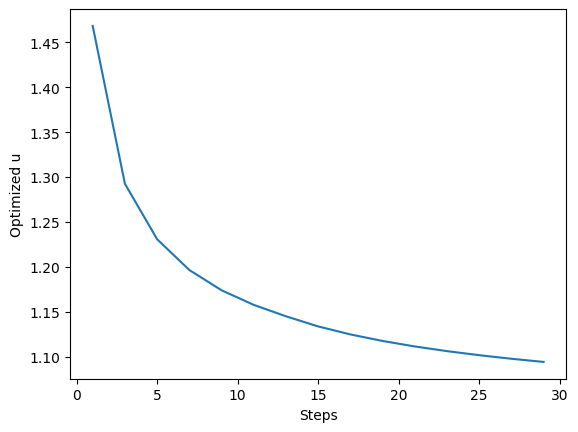

In [9]:
plt.plot(steps, res)
plt.xlabel("Steps")
plt.ylabel("Optimized u")

Different expiries and strike levels  - step=1

In [17]:
res=[]
r=0.05
T=np.linspace(0.1, 2, 40)
S0=100
sigma=0.5
K=np.arange(70, 140, 5)
for i in T:
    res.append([BS_calibrator(r, i, S0, sigma, j, 1)[0] for j in K])

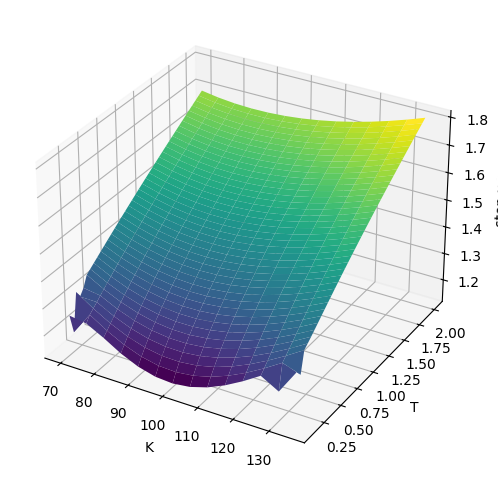

In [18]:
data = np.array(res)
X, Y = np.meshgrid(K, T)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, cmap='viridis')
ax.set_xlabel("K")
ax.set_ylabel("T")
ax.set_zlabel("step up")
plt.show()

Same with r=0

C:\Users\takac\AppData\Local\Temp\ipykernel_10256\945115983.py:5: RuntimeWarning: invalid value encountered in divide
  p_up = ((1 / discount_factor - spot_mult_down) /(spot_mult_up - spot_mult_down))


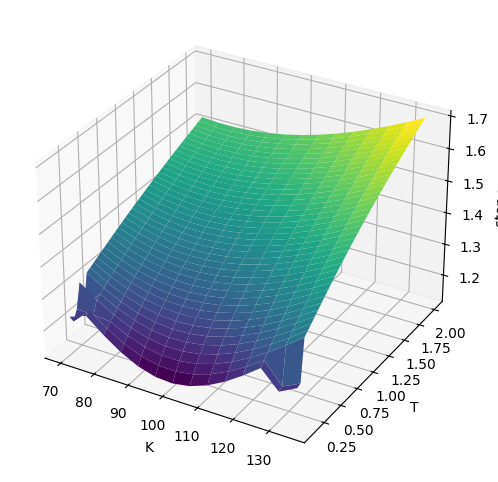

In [19]:
res=[]
r=0
T=np.linspace(0.1, 2, 40)
S0=100
sigma=0.5
K=np.arange(70, 140, 5)
for i in T:
    res.append([BS_calibrator(r, i, S0, sigma, j, 1)[0] for j in K])
    
data = np.array(res)
X, Y = np.meshgrid(K, T)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, cmap='viridis')
ax.set_xlabel("K")
ax.set_ylabel("T")
ax.set_zlabel("step up")
plt.show()